Increasing the CNN's capacity, regularization and more
===============

Starts at section 8.5.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

For ASCII plots of training progress

In [3]:
import asciichartpy
from IPython.display import clear_output

Used for logging

In [4]:
import datetime 

For loading previously computed model accuracy

In [5]:
import pickle

## Selects device

Selected appropriate device

In [6]:
if torch.cuda.is_available(): 
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [7]:
device

device(type='mps')

## Image dataset

In [8]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [9]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [10]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [11]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

## Useful definitions 

In [12]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

Training loop, including progress

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    lossList=[]
    epochList=[]
    
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # moves data to GPU
            labels = labels.to(device=device) # moves labels to GPU
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        lossList.append(np.log10(loss_train/len(train_loader)))
        epochList.append(epoch)
        clear_output(wait=True)
        print("              ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),"| Epoch", epoch, "| Loss",round(loss_train/len(train_loader),4))
        print(asciichartpy.plot(lossList, {'height': 10}))

Gets accuracy from training and validation data

In [14]:
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

## Increasing the width

Let's increase the network's width and see the effect on performance and accuracy

In [15]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Trains the wider CNN on the GPU

In [16]:
%%time
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

               2024-10-30 10:16:54 | Epoch 100 | Loss 0.0845
   -0.26  ┼╮
   -0.33  ┤╰╮
   -0.41  ┤ ╰─╮
   -0.48  ┤   ╰──────────╮
   -0.55  ┤              ╰──────────────╮
   -0.63  ┤                             ╰──────────────╮
   -0.70  ┤                                            ╰─────────────╮
   -0.78  ┤                                                          ╰───────────╮
   -0.85  ┤                                                                      ╰───────────╮
   -0.92  ┤                                                                                  ╰─────────╮
   -1.00  ┤                                                                                            ╰──────
   -1.07  ┤
CPU times: user 52.8 s, sys: 8.16 s, total: 1min
Wall time: 1min 39s


In [17]:
validate(model, train_loader, val_loader)

Accuracy train: 0.97
Accuracy val: 0.89


{'train': 0.9653, 'val': 0.889}

### Loads accuracy from previous notebook

In [19]:
# Read the dictionary from the binary file
with open('model-accuracy-dict.pkl', 'rb') as pickleFile:
    all_acc_dict = pickle.load(pickleFile)

In [20]:
all_acc_dict["width"] = validate(model, train_loader, val_loader)

Accuracy train: 0.97
Accuracy val: 0.89


### More elegance

One could define a class that takes as input the width of the CNN. Here is how that would go:

```python
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
```

The training would proceed in essentially the same way: 

```python
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
```

Counting the number of parameters

In [23]:
# sum(p.numel() for p in model.parameters())

38386

## L2 regularization

Implementing weight penalties. We can implement regularization pretty easily by adding a term to the loss. After computing the loss, whatever the loss function is, we can iterate the parameters of the model, sum their respective square (for L2) or abs (for L1), and backpropagate:

In [23]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    lossList=[]
    epochList=[]
    
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # L2 regularization
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

        lossList.append(np.log10(loss_train/len(train_loader)))
        epochList.append(epoch)
        clear_output(wait=True)
        print("              ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),"| Epoch", epoch, "| Loss",round(loss_train/len(train_loader),4))
        print(asciichartpy.plot(lossList, {'height': 10}))        

### Loads trained model from disk

CNN architecture, as defined in the previous notebook:

In [26]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

/var/folders/15/7jdf1bc547qf4cwtcvv8g05h0000gn/T/ipykernel_27537/517758729.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(data_p

<All keys matched successfully>

### Training

In [28]:
%%time
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

               2024-10-30 10:36:59 | Epoch 100 | Loss 0.2055
   -0.22  ┤
   -0.27  ┼╮
   -0.31  ┤╰╮
   -0.35  ┤ ╰╮
   -0.39  ┤  ╰─╮
   -0.43  ┤    ╰───╮
   -0.48  ┤        ╰──────────╮
   -0.52  ┤                   ╰─────────────╮
   -0.56  ┤                                 ╰───────────────╮
   -0.60  ┤                                                 ╰───────────────────╮
   -0.65  ┤                                                                     ╰─────────────────────╮
   -0.69  ┤                                                                                           ╰───────


Inserts accuracy into dictionary

In [29]:
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

Accuracy train: 0.91
Accuracy val: 0.89


## Dropout

> The idea behind dropout is indeed simple: zero out a random fraction of outputs from neurons across the network, where the randomization happens at each training iteration. This procedure effectively generates slightly different models with different neuron topologies at each iteration, giving neurons in the model less chance to coordinate in the memorization process that happens during overfitting. An alternative point of view is that dropout perturbs the features being generated by the model, exerting an effect that is close to augmentation, but this time throughout the network.
> 
> In PyTorch, we can implement dropout in a model by adding an nn.Dropout module between the nonlinear activation function and the linear or convolutional module of the subsequent layer. As an argument, we need to specify the probability with which inputs will be zeroed out. 

In [30]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4) # <=== DROPOUT
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4) # <=== DROPOUT
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out) # <=== DROPOUT
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out) # <=== DROPOUT
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [31]:
%%time
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

               2024-10-30 10:43:40 | Epoch 100 | Loss 0.2406
   -0.23  ┤
   -0.27  ┼╮
   -0.30  ┤╰╮
   -0.34  ┤ ╰╮
   -0.37  ┤  ╰──╮
   -0.41  ┤     ╰──╮
   -0.44  ┤        ╰───────╮
   -0.48  ┤                ╰───────────────╮
   -0.51  ┤                                ╰────────────────╮
   -0.55  ┤                                                 ╰────────────────────╮
   -0.58  ┤                                                                      ╰──────────────────────╮
   -0.62  ┤                                                                                             ╰─────


In [32]:
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

Accuracy train: 0.90
Accuracy val: 0.88


## Batch normalization

In [46]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [47]:
%%time
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

               2024-10-30 11:26:23 | Epoch 100 | Loss 0.0076
   -0.33  ┤
   -0.50  ┼─╮
   -0.66  ┤ ╰───────────╮
   -0.82  ┤             ╰──────────────╮
   -0.98  ┤                            ╰───────────╮
   -1.14  ┤                                        ╰─────────╮
   -1.31  ┤                                                  ╰─────────╮╭╮   ╭──╮
   -1.47  ┤                                                            ╰╯╰───╯  ╰╮
   -1.63  ┤                                                                      ╰───────╮
   -1.79  ┤                                                                              ╰──────╮
   -1.96  ┤                                                                                     ╰─────────╮
   -2.12  ┤                                                                                               ╰───
CPU times: user 1min 6s, sys: 9.05 s, total: 1min 15s
Wall time: 1min 48s


In [35]:
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

Accuracy train: 0.99
Accuracy val: 0.88


## Increasing the depth with ResNet

Depth allows a model to better deal with hierarchical information

Dealing with vanishing gradients with residual networks (ResNets). This opened the doors to networks with 100 layers, beating competitions in computer vision.

The skip connection is the trick.

![img description](IMG_EE367CCDE83A-1.jpeg)

### Regular CNN

In [37]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [38]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

               2024-10-30 11:02:58 | Epoch 100 | Loss 0.098
   -0.16  ┤
   -0.24  ┼─╮
   -0.32  ┤ ╰╮
   -0.39  ┤  ╰─╮
   -0.47  ┤    ╰───╮
   -0.55  ┤        ╰─────────────────╮
   -0.62  ┤                          ╰────────────────╮
   -0.70  ┤                                           ╰───────────────╮
   -0.78  ┤                                                           ╰────────────╮
   -0.85  ┤                                                                        ╰───────────╮
   -0.93  ┤                                                                                    ╰─────────╮
   -1.01  ┤                                                                                              ╰────


In [39]:
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

Accuracy train: 0.95
Accuracy val: 0.89


### ResNet

Effects of jump connections:

> Thinking about backpropagation, we can appreciate that a skip connection, or a sequence of skip connections in a deep network, creates a direct path from the deeper parameters to the loss. This makes their contribution to the gradient of the loss more direct, as partial derivatives of the loss with respect to those parameters have a chance not to be multiplied by a long chain of other operations.
> 
> It has been observed that skip connections have a beneficial effect on convergence especially in the initial phases of training. Also, the loss landscape of deep residual networks is a lot smoother than feed-forward networks of the same depth and width.

In [40]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) # NOTICE THE SKIP CONNECTION
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [41]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

               2024-10-30 11:05:07 | Epoch 100 | Loss 0.1081
   -0.18  ┼╮
   -0.27  ┤╰╮
   -0.35  ┤ ╰─╮
   -0.43  ┤   ╰───────╮
   -0.51  ┤           ╰──────────────╮
   -0.60  ┤                          ╰───────────────╮
   -0.68  ┤                                          ╰───────────────╮
   -0.76  ┤                                                          ╰────────────╮
   -0.84  ┤                                                                       ╰──────────╮
   -0.93  ┤                                                                                  ╰─────────╮    ╭─
   -1.01  ┤                                                                                            ╰────╯
   -1.09  ┤


In [42]:
all_acc_dict["res"] = validate(model, train_loader, val_loader)

Accuracy train: 0.97
Accuracy val: 0.90


## Very deep models

How to build a NN with 100 layers?

Define a building block (`ResBlock` below) and then build a network using a loop (`NetResDeep`).

![img description](IMG_2E25026BA790-1.jpeg)

### Define

First create a module subclass whose sole job is to provide the computation for one block—that is, one group of convolutions, activation, and skip connection:

In [48]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

To use the blocks, first in `init` we create `nn.Sequential` containing a list of `ResBlock` instances. `nn.Sequential` will ensure that the output of one block is used as input to the next. It will also ensure that all the parameters in the block are visible to Net. Then, in forward, we just call the sequential to traverse the 100 blocks and generate the output:

In [49]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

### Train

<div class="alert alert-info"><h4>ATTENTION</h4><p>
This will take about an hour to train.
</p></div>

In [50]:
%%time
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

               2024-10-30 12:01:53 | Epoch 100 | Loss 0.0488
   -0.18  ┤
   -0.29  ┼╮
   -0.39  ┤╰╮
   -0.50  ┤ ╰───╮
   -0.60  ┤     ╰──────╮
   -0.71  ┤            ╰─────╮     ╭╮  ╭╮                                 ╭╮
   -0.81  ┤                  ╰─────╯╰──╯╰───╮╭╮ ╭╮                        │╰╮       ╭╮
   -0.92  ┤                                 ╰╯╰─╯╰─╮ ╭╮  ╭╮           ╭╮  │ ╰─╮╭╮ ╭╮│╰────╮             ╭╮
   -1.02  ┤                                        ╰─╯╰─╮│╰─╮         │╰╮ │   ╰╯╰─╯││     ╰───╮        ╭╯│
   -1.13  ┤                                             ╰╯  ╰──╮╭─╮ ╭─╯ │ │        ││         ╰─╮╭─╮ ╭─╯ │
   -1.23  ┤                                                    ╰╯ ╰─╯   ╰─╯        ╰╯           ╰╯ ╰╮│   ╰────
   -1.34  ┤                                                                                         ╰╯
CPU times: user 18min 16s, sys: 2min 2s, total: 20min 18s
Wall time: 34min 48s


In [51]:
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

Accuracy train: 0.98
Accuracy val: 0.88


## Comparing the different models

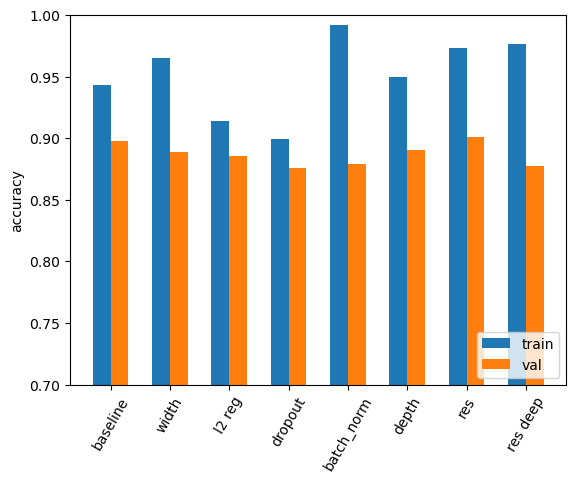

In [52]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()